# hold_peaks

In [1]:
import porespy as ps
from IPython.display import Markdown as show
show(ps.tools.show_docstring(ps.filters.hold_peaks))

---
 ## Documentation for ``hold_peaks``
 ---
**<span style="color:purple">hold&#95;peaks</span>_(im, axis=-1)_**


Replaces each voxel with the highest value along the given axis.


#### Parameters
* im : <b><i>ndarray</i></b>  A greyscale image whose peaks are to be found.
* axis : <b><i>int</i></b>  The axis along which the operation is to be applied.

#### Returns
* result : <b><i>ND-array</i></b>  A copy of ``im`` with each voxel is replaced with the highest value along
	the given axis.

#### Notes
"im" must be a greyscale image. In case a Boolean image is fed into this
method, it will be first converted to float values [0.0,1.0] before proceeding.
---

## Import packages

In [2]:
import numpy as np
import porespy as ps
import scipy.ndimage as spim
import matplotlib.pyplot as plt
import skimage

## Create image and variables:

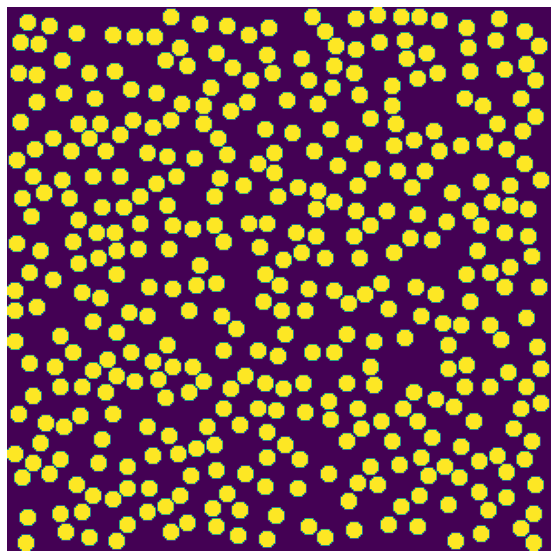

In [3]:
im = np.zeros([300, 300])
im = ps.generators.RSA(im, radius=5, volume_fraction=0.3)
im = im.astype(np.float32)
plt.figure(figsize=[10, 10])
plt.axis(False)
plt.imshow(im)

#default values:
axis=-1

## Apply filter function:
With different parameters

Text(0.5, 1.0, 'axis = 0')

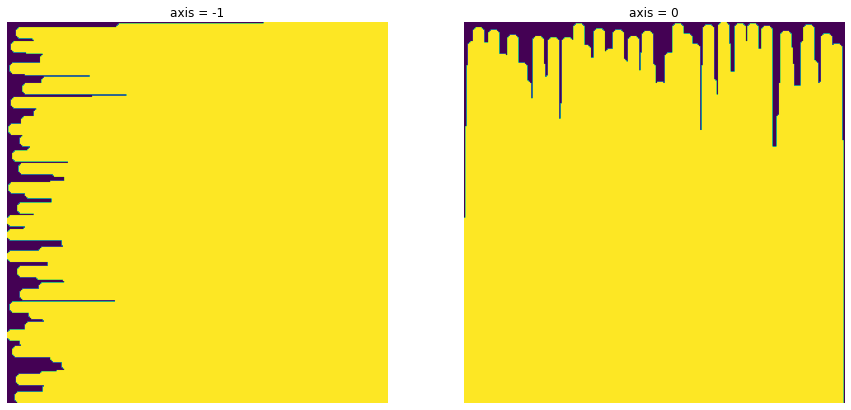

In [4]:
x = ps.filters.hold_peaks(im=im, axis=axis)
xx = ps.filters.hold_peaks(im=im, axis=0)

fig, ax = plt.subplots(1, 2, figsize=[15, 15]);
ax[0].imshow(x);
ax[1].imshow(xx);
ax[0].axis(False)
ax[1].axis(False)
ax[0].set_title('axis = -1')
ax[1].set_title('axis = 0')